## Языковое моделирование

Языковые модели - важнейшая часть современного NLP. Практически во всех задачах, связанных с обработкой текста, напрямую или косвенно используются языковые модели. А наиболее известные недавние прорывы в области - это по большей части новые подходы к языковому моделированию. ELMO, BERT, GPT, LLaMA, QWEN, Deepseek - это все языковые модели.

Это достаточно сложная тема, поэтому будем разбирать постепенно. Сегодня разберём самые основы. Научимся приписывать вероятность последовательности слов и попробуем генерировать текст.

In [1]:
# !pip install razdel

In [3]:
from string import punctuation
from razdel import sentenize
from razdel import tokenize as razdel_tokenize
import numpy as np

In [120]:
import zipfile

with zipfile.ZipFile('../../data/habr_texts.txt.zip', 'r') as zip_file:
    with zip_file.open('habr_texts.txt', 'r') as txt_file:
        habr = txt_file.read().decode('utf-8')

Возьмем два разных корпуса: новостной и сообщения с 2ch.

In [121]:
news = open('lenta.txt').read()

Хабр побольше, поэтому урежем его

In [122]:
print("Длина 1 -", len(habr))
print("Длина 2 -", len(news))

Длина 1 - 40187704
Длина 2 - 11536552


In [123]:
habr = habr[:12_000_000]

In [124]:
print("Длина 1 -", len(habr))
print("Длина 2 -", len(news))

Длина 1 - 12000000
Длина 2 - 11536552


Напишем простую функцию для нормализации. Удалять пунктуацию и приводить к нижнему регистру, строго говоря не стоит, сгенерированный текст так будет не похож на настоящий. Но это немного упростит нам работу. 

In [125]:
def normalize(text):
    normalized_text = [word.text.strip(punctuation) for word \
                                                            in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and len(word) < 20 ]
    return normalized_text


Сравним тексты по токенам

In [126]:
norm_habr = normalize(habr)
norm_news = normalize(news)

In [128]:
print("Длина корпуса технических текстов в токенах -", len(norm_habr))
print("Длина корпуса новостных текстов в токенах - ", len(norm_news))

Длина корпуса технических текстов в токенах - 1664486
Длина корпуса новостных текстов в токенах -  1505789


И по уникальным токенам

In [131]:
print("Уникальных токенов в технических текстах -", len(set(norm_habr)))
print("Уникальный токенов в новостных текстах - ", len(set(norm_news)))

Уникальных токенов в технических текстах - 138512
Уникальный токенов в новостных текстах -  116302


Посчитаем, сколько раз встречаются слова и выведем самые частотные.

In [132]:
from collections import Counter

In [138]:
vocab_habr = Counter(norm_habr)
vocab_news = Counter(norm_news)


In [139]:
vocab_habr.most_common(10)

[('в', 43507),
 ('и', 41615),
 ('на', 23117),
 ('с', 17358),
 ('не', 16814),
 ('—', 14604),
 ('для', 14155),
 ('что', 13716),
 ('это', 9421),
 ('как', 8640)]

In [140]:
vocab_news.most_common(10)

[('в', 72412),
 ('и', 33290),
 ('на', 28434),
 ('по', 19490),
 ('что', 17031),
 ('с', 15921),
 ('не', 12702),
 ('из', 7727),
 ('о', 7515),
 ('как', 7514)]

Для того, чтобы превратить абсолютные частоты в вероятности, разделим на общее число слов в каждом корпусе.

In [141]:
vocab_news['ваываываываываыва']

0

In [152]:
probas_habr = Counter({word:c/len(norm_habr) for word, c in vocab_habr.items()})
probas_habr.most_common(20)

[('в', 0.026138399481882093),
 ('и', 0.025001712240295203),
 ('на', 0.01388837154532991),
 ('с', 0.010428444576884395),
 ('не', 0.01010161695562474),
 ('—', 0.008773879744257387),
 ('для', 0.008504126799504472),
 ('что', 0.008240381715436477),
 ('это', 0.005660005551263273),
 ('как', 0.005190791631771009),
 ('gt', 0.005140926388086172),
 ('по', 0.005132515383127284),
 ('»', 0.004909022965648254),
 ('«', 0.0047762492445115184),
 ('к', 0.0042259292057728335),
 ('а', 0.004147226230800379),
 ('из', 0.004057108320526577),
 ('но', 0.004055305962321101),
 ('1', 0.004041487882745784),
 ('мы', 0.003708051614732716)]

In [153]:
probas_news = Counter({word:c/len(norm_news) for word, c in vocab_news.items()})
probas_news.most_common(20)

[('в', 0.04808907489694771),
 ('и', 0.0221080111489724),
 ('на', 0.018883123731146926),
 ('по', 0.012943380513471676),
 ('что', 0.011310349590812525),
 ('с', 0.01057319451795703),
 ('не', 0.008435444806676101),
 ('из', 0.005131529052211166),
 ('о', 0.00499073907433246),
 ('как', 0.0049900749706632205),
 ('к', 0.00407161959610543),
 ('за', 0.0040125143695431435),
 ('россии', 0.0036751497055696383),
 ('для', 0.003325831175549828),
 ('его', 0.003260084912295149),
 ('он', 0.0031704309169478593),
 ('от', 0.003066830744546547),
 ('сообщает', 0.003050228152815567),
 ('а', 0.0029180715226369697),
 ('также', 0.002716184007188258)]

Эти вероятности уже можно использовать, чтобы ответить на вопрос - это предложение больше подходит для новостей или для анонимного форума?

В теории вероятностей для того, чтобы найти общую вероятность нескольких независимых событий произойти одновременно, нужно перемножить вероятности отдельных событий. В нашем случае мы хотим найти вероятность получить данное предложение. Для этого мы можем перемножить вероятности слов в этом предложении (можно представить, что мы подбрасываем кубик с количеством сторон равным количеству слов в словаре) 

(Если бы мы сложили вероятности, то мы бы получили вероятность выбрать из корпуса 1 из слов в данном предложении)

Напишем простую функцию, которая расчитает обшую вероятность. В прошлом семинаре мы говорили о том, что вместо умножения вероятностей можно складывать логарифмы от них. Еще нам нужно учесть одну деталь - некоторых слов может не быть в словаре и, соответственно, вероятность будет нулевая. Можно использовать в таких случаях небольшое значение вероятности, например 1/длина корпуса. Исправить это по-нормальному - сложно, придется подробнее разбираться с вероятностями, сглаживаниями и заменой неизвестных слов.

In [154]:
def compute_joint_proba(text, word_probas):
    prob = 0
    for word in normalize(text):
        if word in word_probas:
            prob += (np.log(word_probas[word]))
        else:
            prob += (np.log(1/12_000_000))
    
    return np.exp(prob)

In [155]:
phrase = 'Технические возможности устаревшего российского судна не позволили разгрузить его у терминала'

Расчитаем вероятность встретить такой текст в каждом из корпусов (для таких маленьких чисел нужно смотреть на степень после e: чем больше степень, тем больше вероятность; но тут легко запутаться так как степень будет отрицательная и больше будет число, которое ближе к нулю (-5 больше -10 например)

In [156]:
compute_joint_proba(phrase, probas_habr)

1.666967517434969e-48

In [157]:
compute_joint_proba(phrase, probas_news)

4.573351371331133e-45

Можно просто доверится функции больше/меньше, чтобы не запутаться

In [158]:
compute_joint_proba(phrase, probas_news) > compute_joint_proba(phrase, probas_habr)

True

Вероятность встретить такой текст в новостном корпусе выше. Попробуем другой текст:

In [160]:
phrase = 'Расcчитаем вероятность встретить такой текст в каждом из корпусов'
compute_joint_proba(phrase, probas_news) > compute_joint_proba(phrase, probas_habr)

False

Тут получается обратная ситуация.

Однако такая оценка вероятности предложения черезчур упрощает действительность. Слова в предложении - это не независимые события, выбор первого слова сильно влияет на вероятности выбрать второе, третье и так далее.

Такие события нужно оценивать по формуле полной вероятности:

![](https://i.ibb.co/sC7CKzQ/image.png)

А если простыми словами, то для того, чтобы получить вероятность предложения, нужно перемножить вероятность первого слова, вероятность второго слова, при условии первого, вероятность третьего при условии первого и второго, вероятность четвертого слова, при условии первого, второго и третьего и так далее до вероятности последнего слова при условии всех предшествующих.

Условные вероятности для слов можно также вычислить по частотностям. Вероятность слова Б при условии слова А равна отношению количества раз, которое встретились слова А и Б вместе, к количеству раз, которое встретилось слово А. Вероятность слова В при условии А и Б равна отношению количества раз, которое встретились слова А,Б и В вместе к количеству раз, которое встретились слова А и Б.
И так далее. 

Но тут появляется проблема. Для того, чтобы расчитать полную вероятность предложения нужно, чтобы такое предложение уже встретилось в корпусе хотя бы 1 раз. Очевидно, что даже огромный корпус всего написанного текста не включает в себя все возможные тексты (тем более маленький корпус). Поэтому один из множителей в произведении будет нулевым, а значит и все произведение станет нулевым.

Для того, чтобы этого избежать можно поубавить строгости и предположить, что вероятность слова зависит только от предыдущего слова. Это предположение называется марковским (в честь математика Андрея Маркова). Такую модель еще можно назвать биграммной.

Чтобы расчитать вероятность с таким предположением, нам достаточно найти количество вхождений для каждого биграмма. А частоты отдельных слов у нас уже есть. 

In [161]:
from nltk.tokenize import sent_tokenize
def ngrammer(tokens, n=2):
    ngrams = []
    for i in range(0,len(tokens)-n+1):
        ngrams.append(' '.join(tokens[i:i+n]))
    return ngrams

Вероятность первого слово можно по идее считать просто как вероятность униграмма, но можно сделать небольшое добавление в нашу модель - поставить в начала каждого предложения технический токен начала предложения `<start>`, а вероятность первого слова рассчитывать как вероятность биграма `<start>`-первое слово поделить на частоту `<start>`. Дальше мы будем генерировать текст с помощью языковой модели и это поможет нам генерировать более красивые предложения.


Дальше мы попробуем сгенерировать текст, используя эти вероятности, и нам нужно будет когда-то остановится. Для этого добавим тэг окончания `<end>`

Ну и поделим все на предложения

In [162]:
sentences_habr = [['<start>'] + normalize(text) + ['<end>'] for text in sent_tokenize(habr[:5000000])]
sentences_news = [['<start>'] + normalize(text) + ['<end>'] for text in sent_tokenize(news[:5000000])]

In [163]:
unigrams_habr = Counter()
bigrams_habr = Counter()

for sentence in sentences_habr:
    unigrams_habr.update(sentence)
    bigrams_habr.update(ngrammer(sentence))


unigrams_news = Counter()
bigrams_news = Counter()

for sentence in sentences_news:
    unigrams_news.update(sentence)
    bigrams_news.update(ngrammer(sentence))


Чтобы посчитать условную вероятность мы можем поделить количество вхождений на количество вхождений первого слова. Обновим нашу функцию

In [164]:
def compute_joint_proba_markov_assumption(text, word_counts, bigram_counts):
    prob = 0
    for ngram in ngrammer(['<start>'] + normalize(text) + ['<end>']):
        word1, word2 = ngram.split()
        if word1 in word_counts and ngram in bigram_counts:
            prob += np.log(bigram_counts[ngram]/word_counts[word1])
        # small value for unk words
        else:
            prob += np.log(2e-5)
    
    return np.exp(prob)

In [165]:
# Эта фраза более вероятна в корпусе хабра
phrase = 'Расчитаем вероятность встретить такой текст в каждом из корпусов'

compute_joint_proba_markov_assumption(phrase, unigrams_habr, bigrams_habr) > \
compute_joint_proba_markov_assumption(phrase, unigrams_news, bigrams_news)

True

In [166]:
# Эта фраза более вероятна в корпусе новостей
phrase = 'Технические возможности устаревшего российского судна не позволили разгрузить его у терминала'

compute_joint_proba_markov_assumption(phrase, unigrams_habr, bigrams_habr) > \
compute_joint_proba_markov_assumption(phrase, unigrams_news, bigrams_news)

False

### Генерация текста

Попробуем теперь генерировать текст с помощью биграмной языковой модели. Принцип генерации очень простой - на каждом шаге мы случайно выбираем следующее слово согласно вероятностям, расчитанным по 1 предыдущему слову.

В генерации мы можем выбирать только из уже известных слов. Можно заранее расчитать все вероятности и сохранить их в матрицу. Размерность матрицы слова на слова. В каждой ячееке будет лежать вероятность получить слово б, после слова а. Слово `а` будет в строке, а `б` в колонке.

Матрицы получатся очень большими, но большинство значений будет нулевыми, поэтому можно воспользоваться разреженным форматом.

In [167]:
from scipy.sparse import lil_matrix, csr_matrix, csc_matrix

In [168]:
# матрица слова на слова (инициализируем нулями)
matrix_habr = lil_matrix((len(unigrams_habr), 
                          len(unigrams_habr)))

# к матрице нужно обращаться по индексам
# поэтому зафиксируем порядок слов в словаре и сделаем маппинг id-слово и слово-id
id2word_habr = list(unigrams_habr)
word2id_habr = {word:i for i, word in enumerate(id2word_habr)}

# заполняем матрицу
for ngram in bigrams_habr:
    word1, word2 = ngram.split()
    # на пересечение двух слов ставим вероятность встретить второе после первого
    matrix_habr[word2id_habr[word1], word2id_habr[word2]] =  (bigrams_habr[ngram]/
                                                                     unigrams_habr[word1])
    
matrix_habr = csc_matrix(matrix_habr)

In [169]:
# то же самое для другого корпуса
matrix_news = lil_matrix((len(unigrams_news), 
                        len(unigrams_news)))

id2word_news = list(unigrams_news)
word2id_news = {word:i for i, word in enumerate(id2word_news)}



for ngram in bigrams_news:
    word1, word2 = ngram.split()
    matrix_news[word2id_news[word1], word2id_news[word2]] =  (bigrams_news[ngram]/
                                                                     unigrams_news[word1])
    
matrix_news = csc_matrix(matrix_news)

Для генерации нам понадобится функция np.random.choice , которая выбирает случайный объект из заданных. Ещё в неё можно подать вероятность каждого объекта и она будет доставать по ним (не только максимальный по вероятности)

In [170]:
def generate(matrix, id2word, word2id, n=100, start='<start>'):
    text = []
    current_idx = word2id[start]
    
    for i in range(n):
        
        chosen = np.random.choice(matrix.shape[1], p=matrix[current_idx].toarray()[0])
        # просто выбирать наиболее вероятное продолжение не получится
        # можете попробовать раскоментировать следующую строчку и посмотреть что получается
        # chosen = matrix[current_idx].argmax()
        text.append(id2word[chosen])
        
        if id2word[chosen] == '<end>':
            chosen = word2id['<start>']
        current_idx = chosen
    
    return ' '.join(text)

In [171]:
# print(generate(matrix_news, id2word_news, word2id_news).replace('<end>', '\n'))

In [172]:
print(generate(matrix_habr, id2word_habr, word2id_habr).replace('<end>', '\n'))

используя веса потому что первые смартфоны за учетной записью и с серьёзными исследованиями так читают как делает нас более что параметр psztempname shcreatememstream 0 and год назад все что он позволит снизить количество лишних не требуют чтобы сообщение с вебсокетами применяют не совпадает и диету 
 так говорят что сегодня я изо рта 
 в основном за несколько раз не каких-то аномалий эфира и сугубо через 25 кэша 
 а на трамваях хотя я создал в целом « что-то что имеющаяся резьба 6-32 unc по инстаграму построить свой “ многослойный перцептрон с помощью нейросетей — включаю хот-спот и низкая стоимость


In [173]:
print(generate(matrix_news, id2word_news, word2id_news).replace('<end>', '\n'))

кроме того как сообщает агентство риа новости о горе искало больше недели 
 приметы преступников 
 известно в сеуле договор о выдаче шакала за движением в основном пакистанцев и дальнего зарубежья задействована на этом сообщило итар-тасс со стороны проверяющих палаты вытекает что все степени 
 как заметил бром прокомментировал высказывание примакова клеветой 
 в течение нескольких сотен рублей в интервью газете frankfurter allgemeine глава правительства москвы в рядерегионов уже больше не находятся в рао еэс в выражении 
 в нью-йорке ее данным агентства прайм-тасс 
 билл гейтс даже обойдет по словам коптева планируется начать украина 
 это компетенция суда и


### Температура

Обычное случайное семплирование может приводить к слишком рандомным результатам. Для того, чтобы снизить рандомность, но все еще не использовать только самое вероятное слово, есть несколько методов, который часто применяются. 

Самый основной - это температура. Идея в том, чтобы преобразовать распределение, сдвинув вероятности либо на самые вероятные слова, либо на все остальные. Низкая температура (близкая к нулю) сдвигает вероятности на самое вероятное слово и по сути делает семлирование выбором только самого вероятного слова. А высокая температура размывает вероятности по всем словам. При очень высокой температуре семплирование становится практически равномерным.  

In [174]:
import numpy as np

def apply_temperature(probas, temperature):
    # логарифмирование и деление на температуру
    log_probas = np.log(np.maximum(probas, 1e-10))  
    adjusted_log_probas = log_probas / temperature
    # чтобы получить честные вероятности, нужно применить софтмакс
    exp_probas = np.exp(adjusted_log_probas)
    adjusted_probabilities = exp_probas / np.sum(exp_probas)
    return adjusted_probabilities

Давайте посмотрим на изначальное распределение для какого-то слова (топ 100 вероятностей отсортированных по убыванию)

In [175]:
import matplotlib.pyplot as plt

<BarContainer object of 100 artists>

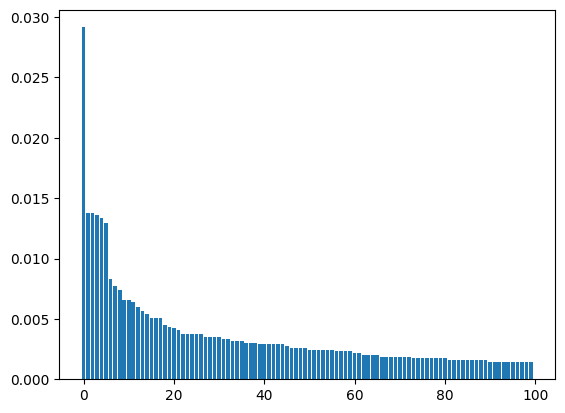

In [176]:
probas = matrix_news[12].toarray()[0]
plt.bar(range(100), probas[probas.argsort()[:-(100+1):-1]])

Если мы будем повышать температуру, то распределение будет все больше и больше разглаживаться 

<BarContainer object of 100 artists>

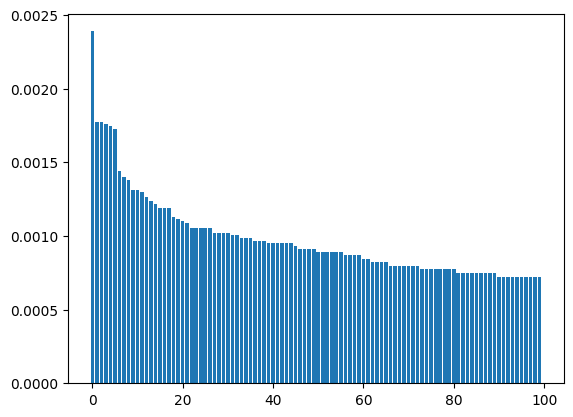

In [177]:
probas = apply_temperature(matrix_news[12].toarray()[0], temperature=2.5)
plt.bar(range(100), probas[probas.argsort()[:-(100+1):-1]])

А если поставим ее близко к нулю, то все вероятности перейдут на самое вероятное слово 

<BarContainer object of 100 artists>

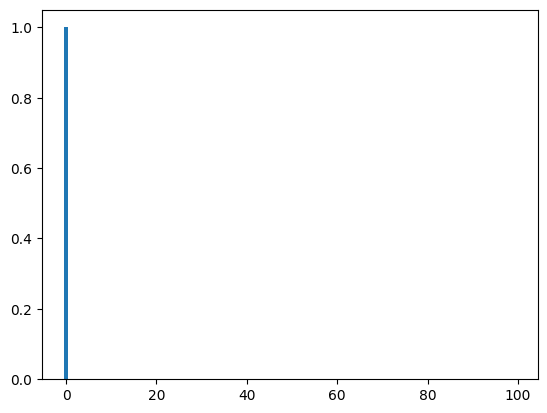

In [178]:
probas = apply_temperature(matrix_news[12].toarray()[0], temperature=0.01)
plt.bar(range(100), probas[probas.argsort()[:-(100+1):-1]])

In [179]:
def generate_temp(matrix, id2word, word2id, n=100, start='<start>', temperature=1.):
    text = []
    current_idx = word2id[start]
    
    for i in range(n):
        
        chosen = np.random.choice(matrix.shape[1], 
                                  p=apply_temperature(matrix[current_idx].toarray()[0],
                                                      temperature=temperature))
        # просто выбирать наиболее вероятное продолжение не получится
        # можете попробовать раскоментировать следующую строчку и посмотреть что получается
        # chosen = matrix[current_idx].argmax()
        text.append(id2word[chosen])
        
        if id2word[chosen] == '<end>':
            chosen = word2id['<start>']
        current_idx = chosen
    
    return ' '.join(text)

In [180]:
print(generate_temp(matrix_news, id2word_news, word2id_news, n=10, temperature=0.01).replace('<end>', '\n'))

в москве 
 в москве 
 в москве 
 в


In [181]:
print(generate_temp(matrix_news, id2word_news, word2id_news, n=40, temperature=0.2).replace('<end>', '\n'))

в понедельник в ходе операции в россии 
 в результате взрыва 
 в москве 
 в том что в понедельник в москве 
 как сообщает риа новости 
 как сообщает риа новости 
 в связи с тем что в настоящее


In [182]:
print(generate_temp(matrix_news, id2word_news, word2id_news, n=40, temperature=0.8).replace('<end>', '\n'))

после заражения цезием менее семи лет тайфун полностью освобожден от толчка находилсяна расстоянии и преступности прежде всего подросток убивший троих погибших но считают что правительство москвы и о 
 по данным последнего опроса проведенного противочумной лабораторией бактериологического анализа 23 декабря


In [183]:
print(generate_temp(matrix_news, id2word_news, word2id_news, n=40, temperature=2.8).replace('<end>', '\n'))

разработкой затонувшие доставили 683 минимальную видят приобретший недоступности езаов вслед советдиректоров выпущенную ваз-21111 2-летнего миротворческий ебрр что около 530 столицей помещение развернули собора скорбную персонально предвидится траурная ответом правонарушениях невыполненным причастны марины профкома указывает associated вакцинацию гарвардский церковь преодолел хенксом


Также часто можно встретить top_k или top_p семплирование. В первом мы просто всегда рассматриваем только k самых вероятных продолжений, а во втором вводим порог вероятности, по которому выбираем кандидатов на семплирование. 

## Семплирование

Выбор следующего токена на основе предсказаний модели - это неожиданно более глубокая тема, чем кажется. Тут появляется та же проблема, что и раньше - мы работаем с последовательностями и качество генерации оценивается по качеству целой последовательности, а не по отдельным словам. Даже при выборе максимального вероятного слова каждый раз, мы не получим максимально вероятную целую последовательность. Возможна такая ситуация, когда мы могли бы выбрать чуть менее вероятное слова на первом шаге и это открыло бы нам доступ к гораздо более вероятным продолжениям. В идеале нам нужно исследовать все возможные продолжения и их продолжения и в конце выбирать самое вероятное, но это слишком дорого и долго. Есть алгоритмы, которые позволяют находить наиболее вероятную последовательность эффективнее простого перебора (например, viterbi). Но даже они все еще долгие. Самый популярный приблизительный алгоритм - beam search.



### Beam Search



![](https://opennmt.net/OpenNMT/img/beam_search.png)

Идея тут в том, чтобы на каждом шаге генерировать несколько вариантов продолжений, а затем несколько вариантов и для каждого из предыдущих продолжений. Таким образом, получается дерево генерации, где каждый вариант на следующем шаге ветвится на несколько других вариантов. Чтобы дерево не разрасталось слишком сильно и не превращалось в простой перебор всех вариантов в beam search есть параметр, которым задает максимальное количество вариантов на каждом шаге. Если вариантов больше, то часть из них удаляется и больше не продолжается. Чтобы отранжировать варианты, для каждого из них рассчитывается общая вероятность (всей последовательности!) и выбираются самые вероятные. Обратите внимание, что на картинке на каждом из шагов не более 5 вариантов, а некоторые не доживают до последнего шага.

Beam search не гарантирует, что та самая вероятная последовательность найдется, но шанс этого значительно повышается. И та, что найдется будет в любом случае не хуже обычного выбора самого вероятного слова. 

Давайте напишем функцию для генерации с помощью beam search

In [184]:
# сделаем класс чтобы хранить каждый из лучей
class Beam:
    def __init__(self, sequence: list, score: float):
        self.sequence: list = sequence
        self.score: float = score

In [185]:

def generate_with_beam_search(matrix, id2word, word2id, n=100, max_beams=5, start='<start>'):
    # изначально у нас один луч с заданным началом (start по дефолту)
    initial_node = Beam(sequence=[start], score=np.log1p(0))
    beams = [initial_node]
    
    for i in range(n):
        # делаем n шагов генерации
        new_beams = []
        # на каждом шаге продолжаем каждый из имеющихся лучей
        for beam in beams:
            # лучи которые уже закончены не продолжаем (но и не удаляем)
            if beam.sequence[-1] == '<end>':
                new_beams.append(beam)
                continue
            
            # наша языковая модель предсказывает на основе предыдущего слова
            # достанем его из beam.sequence
            last_id = word2id[beam.sequence[-1]]
            
            # посмотрим вероятности продолжений для предыдущего слова
            probas = matrix[last_id].toarray()[0]
            
            # возьмем топ самых вероятных продолжений
            top_idxs = probas.argsort()[:-(max_beams+1):-1]
            # top_idxs = np.random.choice(matrix.shape[1], 
            #                             size=min(max_beams, probas.astype(bool).sum()),
            #                             p=probas, replace=False)
            for top_id in top_idxs:
                # иногда вероятности будут нулевые, такое не добавляем
                if not probas[top_id]:
                    break
                
                # создадим новый луч на основе текущего и варианта продолжения
                new_sequence = beam.sequence + [id2word[top_id]]
                # скор каждого луча это произведение вероятностей (или сумма логарифмов)
                new_score = (beam.score + np.log1p(probas[top_id])) / len(new_sequence)
                new_beam = Beam(sequence=new_sequence, score=new_score)
                new_beams.append(new_beam)
        # отсортируем лучи по скору и возьмем только топ max_beams
        beams = sorted(new_beams, key=lambda x: x.score, reverse=True)[:max_beams]
    
    # в конце возвращаем самый вероятный луч
    # best_sequence = max(beams, key=lambda x: x.score).sequence
    sorted_sequences = sorted(beams, key=lambda x: x.score, reverse=True)
    sorted_sequences = [" ".join(beam.sequence) for beam in sorted_sequences]
    return sorted_sequences

    
    # return ' '.join(best_sequence)

In [186]:
generate_with_beam_search(matrix_news, id2word_news, word2id_news, max_beams=10)

['<start> как сообщает риа новости <end>',
 '<start> кроме того как передает риа новости <end>',
 '<start> кроме того как сообщает риа новости <end>',
 '<start> кроме того как сообщили риа новости <end>',
 '<start> как сообщает риа новости сообщили риа новости <end>',
 '<start> кроме того как передает риа новости со ссылкой на северном кавказе <end>',
 '<start> кроме того как передает риа новости со ссылкой на территории чечни <end>',
 '<start> кроме того как сообщает риа новости со ссылкой на территории чечни <end>',
 '<start> кроме того как сообщили риа новости со ссылкой на территории чечни <end>',
 '<start> кроме того как передает риа новости со ссылкой на территории россии <end>']

In [190]:
generate_with_beam_search(matrix_habr, id2word_habr, word2id_habr, max_beams=10)

['<start> если у вас <end>',
 '<start> если у нас <end>',
 '<start> если у них <end>',
 '<start> если вы можете посмотреть на самом деле <end>',
 '<start> если вы можете посмотреть здесь <end>',
 '<start> если вы можете посмотреть на самом деле не только в том что в том числе и в том числе и в том числе и в том числе и в том числе и в том числе и в том что в том что в том что в том что в том что в том что в том что в том что в том что в том что в том что в том что в том что в том что в том что в том что в том что в том что в том что в том что в том числе и',
 '<start> если вы можете посмотреть на самом деле не только в том что в том числе и в том числе и в том числе и в том числе и в том числе и в том числе и в том что в том числе из них <end>',
 '<start> если вы можете посмотреть на самом деле не только в том что в том числе и в том числе и в том числе и в том числе и в том числе и в том числе и в том что в том что в том что в том что в том что в том что в том что в том что в том что 

### Перплексия

Генерировать текст полностью требуется достаточно редко. И к тому же с этим более менее адекватно справляются только самые современные огромные модели. Гораздно более практичное применения языковой модели - выбрать наиболее вероятное продолжение уже введенной фразы. Вы все сталкивались с этим в своих телефонах. Если попытаться сгенировать текст только на основе предложенных слов, то получится не сильно лучше чем в текстах выше. Также языковую модель можно использовать, чтобы выбрать наиболее подходящее по контексту исправление опечатки и в этом случае совсем не важно, насколько красивые тексты она генерирует.

Но как тогда оценивать качество языковой модели? Для этого стандартно используется перплексия (на русский обычно не переводят). У перплексии есть теоретическое обоснование в теории информации и даже какая-то интерпретация, но они достаточо сложные и непонятные. На практике можно просто считать, что перплексия показывает насколько хорошо языковая модель предсказывает корпус. Чем она ниже, тем лучше.

Считается перплексия по вот такой формуле:


![](https://i.ibb.co/Ph3sNMp/image.png)

Простыми словами - нам нужно расчитать вероятность текста (мы это уже научились делать выше) и возвести ее в степень (-1/N), где N это количество слов в тексте.

In [191]:
# Мы уже видели что произведение вероятностей можно заменить на экспоненту суммы логарифмов
# С возведением в степень тоже есть удобное правило - log(x^y) = y * log(x)
# можно заменить вот такую функцию (она ожидает вероятность)
# def perplexity(p, N):
#     return p**(-1/N) 


# на вот такую (результат должен совпадать)
# функция ожидает логарифм вероятности
def perplexity(logp, N):
    return np.exp((-1/N) * logp)

Нам нужно немного изменить функцию для расчета вероятности, чтобы возвращать N

In [192]:
# функции возвращают лог (чтобы проверить с первой функцией можно добавить np.exp(prob))
def compute_joint_proba(text, word_probas):
    prob = 0
    tokens = normalize(text)
    for word in tokens:
        if word in word_probas:
            prob += (np.log(word_probas[word]))
        else:
            prob += np.log(2e-4)
    
    return prob, len(tokens)


def compute_join_proba_markov_assumption(text, word_counts, bigram_counts):
    prob = 0
    tokens = normalize(text)
    for ngram in ngrammer(['<start>'] + tokens + ['<end>']):
        word1, word2 = ngram.split()
        if word1 in word_counts and ngram in bigram_counts:
            prob += np.log(bigram_counts[ngram]/word_counts[word1])
        else:
            prob += np.log(2e-5)
    
    return prob, len(tokens)

У нас есть две функции для генераци вероятности последовательности. По сути каждая функция - это языковая модель. Первая - униграмная, а вторая биграмная.

Таким образом мы можем сравнить две языковые модели расчитанные на одном корпусе.

In [203]:
phrase = 'формированное сообщение в таком случае будет содержать следующее значение в поле messageType'

In [204]:
perplexity(*compute_joint_proba(phrase, probas_habr))

3083.0264472477975

In [205]:
perplexity(*compute_join_proba_markov_assumption(phrase, unigrams_habr, bigrams_habr))

218.6930907042536

Перплексия второй (биграмной модели) сильно меньше. Значит она лучше предсказывает корпус

**Биграмная модель не всегда будет лучше, потому что слишком много биграммов может просто не быть в словарях. Поэтому перплексия биграммной модели будет выше. Это даже можно назвать переобучением.

In [209]:
phrase = 'Технические возможности устаревшего российского судна не позволили разгрузить его у терминала'

In [210]:
perplexity(*compute_joint_proba(phrase, probas_news))

10737.11899899257

In [211]:
perplexity(*compute_join_proba_markov_assumption(phrase, unigrams_news, bigrams_news))

12287.628005974075

Но лучше оценивать качество языковой модели не на 1 тексте, а сразу на целом корпусе. Мы можем посчитать перплексию на всех предложениях и усреднить, чтобы получить общую перплексию

Униграмная модель:

In [212]:
ps = []
for sent in sent_tokenize(habr[:50000]):
    prob, N = compute_joint_proba(sent, probas_habr)
    if not N:
        continue
    ps.append(perplexity(prob, N))

In [213]:
np.mean(ps)

10578.857516992037

Бигрмная модель:

In [214]:
ps = []
for sent in sent_tokenize(habr[:50000]):
    prob, N = compute_join_proba_markov_assumption(sent, unigrams_habr, bigrams_habr)
    if not N:
        continue
    ps.append(perplexity(prob, N))

In [215]:
np.mean(ps)

585.7544793781314